# Calibrating qubits using Qiskit Pulse

Qiskit is an open-source framework for programming quantum computers (Ref. [1](#refs)). Using Qiskit, quantum circuits can be built, simulated and executed on quantum devices.

Qiskit Pulse provides a language for specifying pulse level control (i.e. control of the continuous time dynamics of input signals) of a general quantum device independent of the specific hardware implementation (Ref. [2](#refs)). 

In this tutorial, we show how to implement typical single-qubit calibration and characterization experiments using Qiskit and Qiskit Pulse. These are typically the first round of experiments that would be done in the lab immediately after a device has been fabricated and installed into a system. The presentation is pedagogical, and allows students to explore two-level-system dynamics experimentally. All units are returned as standard SI (i.e., Hz, sec, etc.).

Each experiment gives us more information about the system, which is typically used in subsequent experiments. For this reason, this notebook has to be mostly executed in order.

## Contents

1. [Getting Started](#importing)
2. [Finding the qubit Frequency using a Frequency Sweep](#frequencysweep)
3. [Calibrating and using a $\pi$ Pulse](#calib)    
  3.1 [Calibrating $\pi$ Pulses using a Rabi Experiment](#rabi)    
  3.2 [Determining 0 vs 1](#zerovone)    
  3.3 [Measuring $T_1$ using Inversion Recovery](#T1)    
4. [Determining qubit Coherence](#det_co)    
  4.1 [Measuring the qubit Frequency Precisely using a Ramsey Experiment](#ramsey)    
  4.2 [Measuring $T_2$ using Hahn Echoes](#hahn)    
5. [References](#refs)

## 1. Getting Started <a id="importing"></a>

We'll first get our basic dependencies set up and ready to go. Since we want to use real, noisy devices for our calibration experiments in this notebook, we need to load our IBMQ account and set the appropriate backend.

In [1]:
import warnings
warnings.filterwarnings('ignore')
from qiskit.tools.jupyter import *

In [2]:
from qiskit import IBMQ
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-internal')
backend = provider.get_backend('ibmq_manila')

We verify that the backend supports Pulse features by checking the backend configuration. The config provides us with general information about the structure of the backend setup.

In [3]:
backend_config = backend.configuration()

For instance, we can find the sampling time for the backend pulses within the backend configuration. This will be a very useful value to us as we build and execute our calibration routines.

In [4]:
dt = backend_config.dt
print(f"Sampling time: {dt*1e9} ns")    # The configuration returns dt in seconds, so multiply by
                                        # 1e9 to get nanoseconds

Sampling time: 0.2222222222222222 ns


We can also find timing constraints in the backend configuration.

The position of the measurement pulse is constrained to be an integral multiple of `acquire_alignment`, and the position of the gate is constrained to be an integral multiple of` pulse_alignment`.

In the case of the T1 experiment introduced later, since there is only measurement after delay, it is sufficient to follow `acquire_alignment`. On the other hand, in an experiment where gates and delays are repeated, such as the Ramsey experiment, it is necessary to select the delay so that it is the minimum common multiple of `acquire_alignment` and` pulse_alignment`.

We can use `granurality` to determine the length of the pulse.

In [5]:
backend.configuration().timing_constraints

{'acquire_alignment': 16,
 'granularity': 16,
 'min_length': 64,
 'pulse_alignment': 16}

In [6]:
acquire_alignment = backend.configuration().timing_constraints['acquire_alignment']
granularity = backend.configuration().timing_constraints['granularity']
pulse_alignment = backend.configuration().timing_constraints['pulse_alignment']

In [7]:
import numpy as np

lcm = np.lcm(acquire_alignment, pulse_alignment)
print(f"Least common multiple of acquire_alignment and pulse_alignment: {lcm}")

Least common multiple of acquire_alignment and pulse_alignment: 16


The backend defaults provide a starting point for how to use the backend. It contains estimates for qubit frequencies and default programs to enact basic quantum operators. We can access them with the following:

In [8]:
backend_defaults = backend.defaults()

## 2. Finding the qubit Frequency using a Frequency Sweep <a id="frequencysweep"></a>

We begin by searching for the qubit frequency. The qubit frequency is the difference in energy between the ground and excited states, which we label the $\vert0\rangle$ and $\vert1\rangle$ states, respectively. This frequency will be crucial for creating pulses which enact particular quantum operators on the qubit -- the final goal of our calibration!

With superconducting qubits, higher energy levels are also available, but we fabricate the systems to be anharmonic so that we can control which transition we are exciting. That way, we are able to isolate two energy levels and treat each qubit as a basic two-level system, ignoring higher energy states.

In a typical lab setting, the qubit frequency can be found by sweeping a range of frequencies and looking for signs of absorption using a tool known as a Network Analyzer. This measurement gives a rough estimate of the qubit frequency. Later on, we will see how to do a more precise measurement using a Ramsey pulse sequence.

First, we define the frequency range that will be swept in search of the qubit. Since this can be arbitrarily broad, we restrict ourselves to a window of 40 MHz around the estimated qubit frequency in `backend_defaults`. We step the frequency in units of 1 MHz.

In [9]:
# unit conversion factors -> all backend properties returned in SI (Hz, sec, etc.)
GHz = 1.0e9 # Gigahertz
MHz = 1.0e6 # Megahertz
us = 1.0e-6 # Microseconds
ns = 1.0e-9 # Nanoseconds

# We will find the qubit frequency for the following qubit.
qubit = 0

# The sweep will be centered around the estimated qubit frequency.
center_frequency_Hz = backend_defaults.qubit_freq_est[qubit]        # The default frequency is given in Hz
                                                                    # warning: this will change in a future release
print(f"Qubit {qubit} has an estimated frequency of {center_frequency_Hz / GHz} GHz.")

# scale factor to remove factors of 10 from the data
scale_factor = 1e-7

# We will sweep 40 MHz around the estimated frequency
frequency_span_Hz = 40 * MHz
# in steps of 1 MHz.
frequency_step_Hz = 1 * MHz

# We will sweep 20 MHz above and 20 MHz below the estimated frequency
frequency_min = center_frequency_Hz - frequency_span_Hz / 2
frequency_max = center_frequency_Hz + frequency_span_Hz / 2
# Construct an np array of the frequencies for our experiment
frequencies_GHz = np.arange(frequency_min / GHz, 
                            frequency_max / GHz, 
                            frequency_step_Hz / GHz)

print(f"The sweep will go from {frequency_min / GHz} GHz to {frequency_max / GHz} GHz \
in steps of {frequency_step_Hz / MHz} MHz.")

Qubit 0 has an estimated frequency of 4.9622957311288625 GHz.
The sweep will go from 4.942295731128862 GHz to 4.982295731128862 GHz in steps of 1.0 MHz.


We will create a pulse schedule by defining this frequency as a parameter using the parameter class.
First, we will set the required values duration, sigma, and channel.

Then we will set the pulse flow so that the specified pulses are executed sequentially.
We will define the pulse frequency, the pulse used in the experiment, and the measurement pulse.
Here, the pulse used in the experiment specifies the drive pulse, which is a Gaussian pulse.

At each frequency, we will send a drive pulse of that frequency to the qubit and measure immediately after the pulse. 

In [10]:
def get_closest_multiple_of(vaule, base_number):
    return int(vaule + base_number/2) - (int(vaule + base_number/2) % base_number)

We prepare a function to determine the length of the pulse.

In [11]:
# samples need to be multiples of 16
def get_closest_multiple_of_16(num):
    return get_closest_multiple_of(num, granularity)

We prepare a function to adjust the length of the delay.

In [12]:
# Convert seconds to dt
def get_dt_from(sec):
    return get_closest_multiple_of(sec/dt, lcm)

In [13]:
from qiskit import pulse                  # This is where we access all of our Pulse features!
from qiskit.circuit import Parameter      # This is Parameter Class for variable parameters.
from qiskit.circuit import QuantumCircuit, Gate

# Drive pulse parameters (us = microseconds)
drive_sigma_sec = 0.015 * us                           # This determines the actual width of the gaussian
drive_duration_sec = drive_sigma_sec * 8                # This is a truncating parameter, because gaussians don't have 
                                                        # a natural finite length
drive_amp = 0.05

# Create the base schedule
# Start with drive pulse acting on the drive channel
freq = Parameter('freq')
with pulse.build(backend=backend, default_alignment='sequential', name='Frequency sweep') as sweep_sched:
    drive_duration = get_closest_multiple_of_16(pulse.seconds_to_samples(drive_duration_sec))
    drive_sigma = pulse.seconds_to_samples(drive_sigma_sec)
    drive_chan = pulse.drive_channel(qubit)
    pulse.set_frequency(freq, drive_chan)
    # Drive pulse samples
    pulse.play(pulse.Gaussian(duration=drive_duration,
                              sigma=drive_sigma,
                              amp=drive_amp,
                              name='freq_sweep_excitation_pulse'), drive_chan)

In [14]:
sweep_gate = Gate("sweep", 1, [freq])

qc_sweep = QuantumCircuit(1, 1)

qc_sweep.append(sweep_gate, [0])
qc_sweep.measure(0, 0)
qc_sweep.add_calibration(sweep_gate, (0,), sweep_sched, [freq])

# Create the frequency settings for the sweep (MUST BE IN HZ)
frequencies_Hz = frequencies_GHz*GHz
exp_sweep_circs = [qc_sweep.assign_parameters({freq: f}, inplace=False) for f in frequencies_Hz]

As a sanity check, it's always a good idea to look at the pulse schedule. This is done using `schedule.draw()` as shown below. 

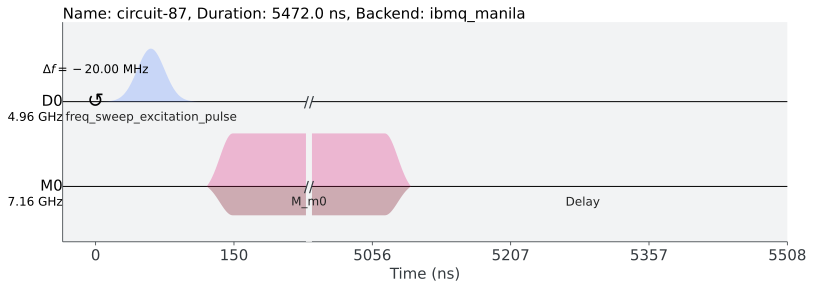

In [15]:
from qiskit import schedule

sweep_schedule = schedule(exp_sweep_circs[0], backend)
sweep_schedule.draw(backend=backend)

We request that each schedule (each point in our frequency sweep) is repeated `num_shots_per_frequency` times in order to get a good estimate of the qubit response.

We also specify measurement settings. `meas_level=0` returns raw data (an array of complex values per shot), `meas_level=1` returns kerneled data (one complex value per shot), and `meas_level=2` returns classified data (a 0 or 1 bit per shot). We choose `meas_level=1` to replicate what we would be working with if we were in the lab, and hadn't yet calibrated the discriminator to classify 0s and 1s. We ask for the `'avg'` of the results, rather than each shot individually.

You may see yet another unit change warning, we can safely ignore this. Finally, we can run the assembled program on the backend using:

In [16]:
num_shots_per_frequency = 1024

# job = backend.run(exp_sweep_circs, 
#                   meas_level=1, 
#                   meas_return='avg', 
#                   shots=num_shots_per_frequency)
job = backend.retrieve_job('638f86c4db0f0dd7139244af')

It is always a good idea to monitor the job status by using `job_monitor()`

In [17]:
from qiskit.tools.monitor import job_monitor
job_monitor(job)

Job Status: job has successfully run


Once the job is run, the results can be retrieved using:

In [18]:
frequency_sweep_results = job.result(timeout=120) # timeout parameter set to 120 seconds

We will extract the results and plot them using `matplotlib`:

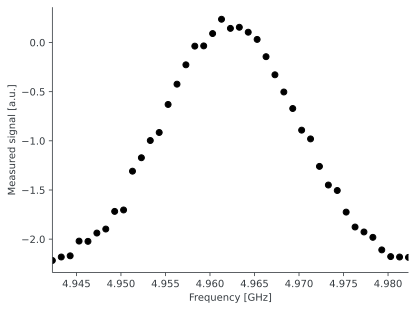

In [19]:
import matplotlib.pyplot as plt

sweep_values = []
for i in range(len(frequency_sweep_results.results)):
    # Get the results from the ith experiment
    res = frequency_sweep_results.get_memory(i)*scale_factor
    # Get the results for `qubit` from this experiment
    sweep_values.append(res[qubit])

plt.scatter(frequencies_GHz, np.real(sweep_values), color='black') # plot real part of sweep values
plt.xlim([min(frequencies_GHz), max(frequencies_GHz)])
plt.xlabel("Frequency [GHz]")
plt.ylabel("Measured signal [a.u.]")
plt.show()

As you can see above, the peak near the center corresponds to the location of the qubit frequency. The signal shows power-broadening, which is a signature that we are able to drive the qubit off-resonance as we get close to the center frequency. To get the value of the peak frequency, we will fit the values to a resonance response curve, which is typically a Lorentzian shape.

In [20]:
from scipy.optimize import curve_fit

def fit_function(x_values, y_values, function, init_params):
    fitparams, conv = curve_fit(function, x_values, y_values, init_params)
    y_fit = function(x_values, *fitparams)
    
    return fitparams, y_fit

In [21]:
fit_params, y_fit = fit_function(frequencies_GHz,
                                 np.real(sweep_values), 
                                 lambda x, A, q_freq, B, C: (A / np.pi) * (B / ((x - q_freq)**2 + B**2)) + C,
                                 [1, 4.975, 1, -2] # initial parameters for curve_fit
                                )

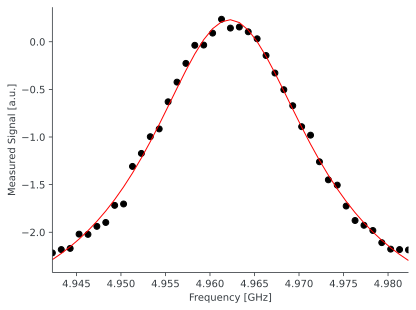

In [22]:
plt.scatter(frequencies_GHz, np.real(sweep_values), color='black')
plt.plot(frequencies_GHz, y_fit, color='red')
plt.xlim([min(frequencies_GHz), max(frequencies_GHz)])

plt.xlabel("Frequency [GHz]")
plt.ylabel("Measured Signal [a.u.]")
plt.show()

In [23]:
A, rough_qubit_frequency, B, C = fit_params
rough_qubit_frequency = rough_qubit_frequency*GHz # make sure qubit freq is in Hz
print(f"We've updated our qubit frequency estimate from "
      f"{round(backend_defaults.qubit_freq_est[qubit] / GHz, 5)} GHz to {round(rough_qubit_frequency/GHz, 5)} GHz.")

We've updated our qubit frequency estimate from 4.9623 GHz to 4.96222 GHz.


## 3. Calibrating and using a $\pi$ Pulse <a id="calib"></a>

### 3.1 Calibrating $\pi$ Pulses using a Rabi Experiment <a id="rabi"></a>

Once we know the frequency of our qubit, the next step is to determine the strength of a $\pi$ pulse. Strictly speaking of the qubit as a two-level system, a $\pi$ pulse is one that takes the qubit from $\vert0\rangle$ to $\vert1\rangle$, and vice versa. This is also called the $X$ or $X180$ gate, or bit-flip operator. We already know the microwave frequency needed to drive this transition from the previous frequency sweep experiment, and we now seek the amplitude needed to achieve a $\pi$ rotation from $\vert0\rangle$ to $\vert1\rangle$. The desired rotation is shown on the Bloch sphere in the figure below -- you can see that the $\pi$ pulse gets its name from the angle it sweeps over on a Bloch sphere.

<img src="images/zero_to_one_X180.png">

We will change the drive amplitude in small increments and measuring the state of the qubit each time. We expect to see oscillations which are commonly named Rabi oscillations, as the qubit goes from $\vert0\rangle$ to $\vert1\rangle$ and back.

In [24]:
# This experiment uses these values from the previous experiment:
# `qubit`,and
# `rough_qubit_frequency`.

# Rabi experiment parameters
num_rabi_points = 50

# Drive amplitude values to iterate over: 50 amplitudes evenly spaced from 0 to 0.75
drive_amp_min = 0
drive_amp_max = 0.75
drive_amps = np.linspace(drive_amp_min, drive_amp_max, num_rabi_points)

In [25]:
# Build the Rabi experiments:
#    A drive pulse at the qubit frequency, followed by a measurement,
#    where we vary the drive amplitude each time.

drive_amp = Parameter('drive_amp')
with pulse.build(backend=backend, default_alignment='sequential', name='Rabi Experiment') as rabi_sched:
    drive_duration = get_closest_multiple_of_16(pulse.seconds_to_samples(drive_duration_sec))
    drive_sigma = pulse.seconds_to_samples(drive_sigma_sec)
    drive_chan = pulse.drive_channel(qubit)
    pulse.set_frequency(rough_qubit_frequency, drive_chan)
    pulse.play(pulse.Gaussian(duration=drive_duration,
                              amp=drive_amp,
                              sigma=drive_sigma,
                              name='Rabi Pulse'), drive_chan)

In [26]:
rabi_gate = Gate("rabi", 1, [drive_amp])

qc_rabi = QuantumCircuit(1, 1)

qc_rabi.append(rabi_gate, [0])
qc_rabi.measure(0, 0)
qc_rabi.add_calibration(rabi_gate, (0,), rabi_sched, [drive_amp])

exp_rabi_circs = [qc_rabi.assign_parameters({drive_amp: a}, inplace=False) for a in drive_amps]

The schedule will look essentially the same as the frequency sweep experiment. The only difference is that we are running a set of experiments which vary the amplitude of the drive pulse, rather than its modulation frequency.

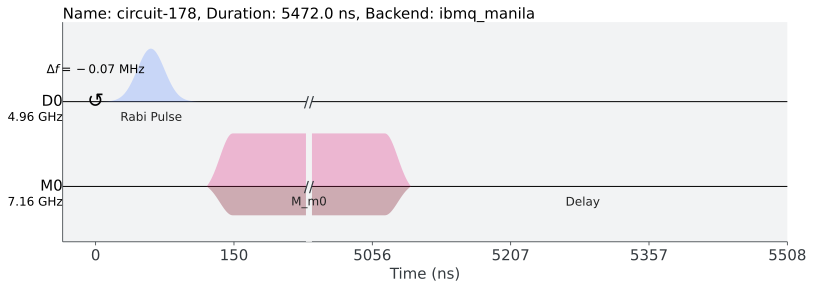

In [27]:
rabi_schedule = schedule(exp_rabi_circs[-1], backend)
rabi_schedule.draw(backend=backend)

In [28]:
num_shots_per_point = 1024

# job = backend.run(exp_rabi_circs, 
#                   meas_level=1, 
#                   meas_return='avg', 
#                   shots=num_shots_per_point)

# job_monitor(job)
job = backend.retrieve_job('63905924db0f0dd8b192495e')

In [29]:
rabi_results = job.result(timeout=120)

Now that we have our results, we will extract them and fit them to a sinusoidal curve. For the range of drive amplitudes we selected, we expect that we will rotate the qubit several times completely around the Bloch sphere, starting from $|0\rangle$. The amplitude of this sinusoid tells us the fraction of the shots at that Rabi drive amplitude which yielded the $|1\rangle$ state.  We want to find the drive amplitude needed for the signal to oscillate from a maximum (all $|0\rangle$ state) to a minimum (all $|1\rangle$ state) -- this gives the calibrated amplitude that enacts a $\pi$ pulse.

In [30]:
# center data around 0
def baseline_remove(values):
    return np.array(values) - np.mean(values)

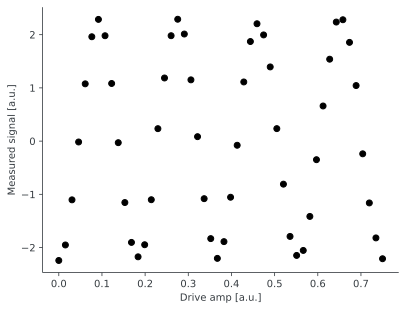

In [31]:
rabi_values = []
for i in range(num_rabi_points):
    # Get the results for `qubit` from the ith experiment
    rabi_values.append(rabi_results.get_memory(i)[qubit] * scale_factor)

rabi_values = np.real(baseline_remove(rabi_values))

plt.xlabel("Drive amp [a.u.]")
plt.ylabel("Measured signal [a.u.]")
plt.scatter(drive_amps, rabi_values, color='black') # plot real part of Rabi values
plt.show()

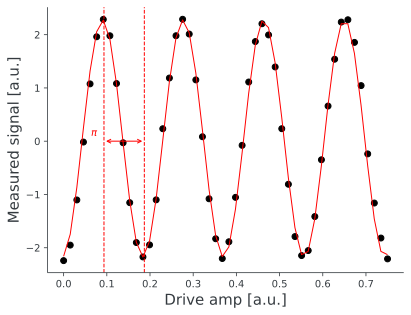

In [32]:
fit_params, y_fit = fit_function(drive_amps,
                                 rabi_values, 
                                 lambda x, A, B, drive_period, phi: (A*np.cos(2*np.pi*x/drive_period - phi) + B),
                                 [2, 0, 0.2, 0])

plt.scatter(drive_amps, rabi_values, color='black')
plt.plot(drive_amps, y_fit, color='red')

drive_period = fit_params[2] # get period of rabi oscillation

plt.axvline(drive_period/2, color='red', linestyle='--')
plt.axvline(drive_period, color='red', linestyle='--')
plt.annotate("", xy=(drive_period, 0), xytext=(drive_period/2,0), arrowprops=dict(arrowstyle="<->", color='red'))
plt.annotate("$\pi$", xy=(drive_period/2-0.03, 0.1), color='red')

plt.xlabel("Drive amp [a.u.]", fontsize=15)
plt.ylabel("Measured signal [a.u.]", fontsize=15)
plt.show()

In [33]:
pi_amp = abs(drive_period / 2)
print(f"Pi Amplitude = {pi_amp}")

Pi Amplitude = 0.09342650821167793


### Our $\pi$ pulse!
Let's define our pulse, with the amplitude we just found, so we can use it in later experiments.

In [34]:
with pulse.build(backend) as pi_pulse:
    drive_duration = get_closest_multiple_of_16(pulse.seconds_to_samples(drive_duration_sec))
    drive_sigma = pulse.seconds_to_samples(drive_sigma_sec)
    drive_chan = pulse.drive_channel(qubit)
    pulse.play(pulse.Gaussian(duration=drive_duration,
                              amp=pi_amp,
                              sigma=drive_sigma,
                              name='pi_pulse'), drive_chan)

### 3.2 Determining 0 vs 1 <a id="zerovone"></a>

Once our $\pi$ pulses have been calibrated, we can now create the state $\vert1\rangle$ with good probability. We can use this to find out what the states $\vert0\rangle$ and $\vert1\rangle$ look like in our measurements, by repeatedly preparing them and plotting the measured signal. This is what we use to build a discriminator, which is simply a function which takes a measured and kerneled complex value (`meas_level=1`) and classifies it as a 0 or a 1 (`meas_level=2`).

In [35]:
# Ground state 
qc_gnd = QuantumCircuit(1, 1)
qc_gnd.measure(0, 0)

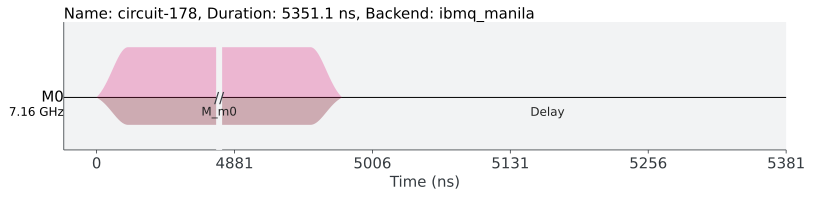

In [36]:
gnd_schedule = schedule(qc_gnd, backend)
gnd_schedule.draw(backend=backend)

In [37]:
# Excited state
with pulse.build(backend=backend, default_alignment='sequential', name='excited state') as exc_schedule:
    drive_chan = pulse.drive_channel(qubit)
    pulse.set_frequency(rough_qubit_frequency, drive_chan)
    pulse.call(pi_pulse)

In [38]:
qc_exc = QuantumCircuit(1, 1)
qc_exc.x(0)
qc_exc.measure(0, 0)

qc_exc.add_calibration("x", (0,), exc_schedule, [])

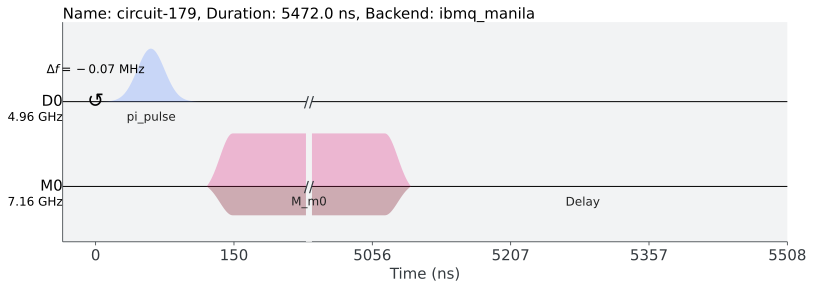

In [39]:
exec_schedule = schedule(qc_exc, backend)
exec_schedule.draw(backend=backend)

We assemble the ground and excited state preparation schedules. Each of these will run `num_shots` times. We choose `meas_level=1` this time, because we do not want the results already classified for us as $|0\rangle$ or $|1\rangle$. Instead, we want kerneled data: raw acquired data that has gone through a kernel function to yield a single complex value for each shot. (You can think of a kernel as a dot product applied to the raw measurement data.)

In [ ]:
# # Execution settings
# num_shots = 1024

# job = backend.run([qc_gnd, qc_exc], 
#                   meas_level=1, 
#                   meas_return='single', 
#                   shots=num_shots)
#job = backend.retrieve_job('6391276dec40c21c43f6119c') #internal
job = backend.retrieve_job('6391dec8ec40c24657f61938') #open
job_monitor(job)

Job Status: job is queued (9)     

In [ ]:
gnd_exc_results = job.result(timeout=120)

Now that we have the results, we can visualize the two populations which we have prepared on a simple scatter plot, showing results from the ground state program in blue and results from the excited state preparation program in red. Note: If the populations irregularly shaped (not approximately circular), try re-running the notebook.

In [ ]:
gnd_results = gnd_exc_results.get_memory(0)[:, qubit]*scale_factor
exc_results = gnd_exc_results.get_memory(1)[:, qubit]*scale_factor

plt.figure()

# Plot all the results
# All results from the ground state are plotted in blue
plt.scatter(np.real(gnd_results), np.imag(gnd_results), 
                s=5, cmap='viridis', c='blue', alpha=0.5, label='state_0')
# All results from the excited state are plotted in red
plt.scatter(np.real(exc_results), np.imag(exc_results), 
                s=5, cmap='viridis', c='red', alpha=0.5, label='state_1')

plt.axis('square')

# Plot a large dot for the average result of the 0 and 1 states.
mean_gnd = np.mean(gnd_results) # takes mean of both real and imaginary parts
mean_exc = np.mean(exc_results)
plt.scatter(np.real(mean_gnd), np.imag(mean_gnd), 
            s=200, cmap='viridis', c='black',alpha=1.0, label='state_0_mean')
plt.scatter(np.real(mean_exc), np.imag(mean_exc), 
            s=200, cmap='viridis', c='black',alpha=1.0, label='state_1_mean')

plt.ylabel('I [a.u.]', fontsize=15)
plt.xlabel('Q [a.u.]', fontsize=15)
plt.title("0-1 discrimination", fontsize=15)

plt.show()

We can clearly see that the two populations of $|0\rangle$ and $|1\rangle$ form their own clusters. Kerneled measurement results (from `meas_level=1`) are classified (into `meas_level=2`) by applying a discriminator which optimally separates these two clusters. Optimal separation is simply a line in the IQ plane, equidistant from the average results we plotted above in the large dot, and normal to the line connecting the two dots.

We can set up a quick classifier function by returning 0 if a given point is closer to the mean of the ground state results, and returning 1 if the point is closer to the average excited state results.

In [ ]:
import math

def classify(point: complex):
    """Classify the given state as |0> or |1>."""
    def distance(a, b):
        return math.sqrt((np.real(a) - np.real(b))**2 + (np.imag(a) - np.imag(b))**2)
    return int(distance(point, mean_exc) < distance(point, mean_gnd))


### 3.3 Measuring $T_1$ using Inversion Recovery <a id="T1"></a>
The $T_1$ time of a qubit is the time it takes for a qubit to decay from the excited state to the ground state. It is important because it limits the duration of meaningful programs we can run on the quantum computer.

Measuring $T_1$ is similar to our previous experiments, and uses the $\pi$ pulse we've calibrated. We again apply a single drive pulse, our $\pi$ pulse, then apply a measure pulse. However, this time we do not apply the measurement immediately. We insert a delay, and vary that delay between experiments. When we plot the measured signal against delay time, we will see a signal that decays exponentially as the qubit relaxes in energy. The decay time is the $T_1$, or relaxation time, of the qubit!

In [ ]:
# T1 experiment parameters
time_max_sec = 450 * us
time_step_sec = 6.5 * us
delay_times_sec = np.arange(1 * us, time_max_sec, time_step_sec)

# We will use the same `pi_pulse` and qubit frequency that we calibrated and used before

In [ ]:
delay = Parameter('delay')
qc_t1 = QuantumCircuit(1, 1)

qc_t1.x(0)
qc_t1.delay(delay, 0)
qc_t1.measure(0, 0)
qc_t1.add_calibration("x", (0,), pi_pulse)

exp_t1_circs = [qc_t1.assign_parameters({delay: get_dt_from(d)}, inplace=False) for d in delay_times_sec]

We can check out our $T_1$ schedule, too. To really get a sense of this experiment, try looking at a couple of the schedules by running the next cell multiple times, with different values of `sched_idx`. You will see the measurement pulse start later as you increase `sched_idx`.

In [ ]:
sched_idx = -1
t1_schedule = schedule(exp_t1_circs[sched_idx], backend)
t1_schedule.draw(backend=backend)

In [ ]:
# Execution settings
num_shots = 256

job = backend.run(exp_t1_circs, 
                  meas_level=1, 
                  meas_return='single', 
                  shots=num_shots)

job_monitor(job)

In [ ]:
t1_results = job.result(timeout=120)

In [ ]:
t1_values = []

for i in range(len(delay_times_sec)):
    iq_data = t1_results.get_memory(i)[:,qubit] * scale_factor
    t1_values.append(sum(map(classify, iq_data)) / num_shots)

plt.scatter(delay_times_sec/us, t1_values, color='black') 
plt.title("$T_1$ Experiment", fontsize=15)
plt.xlabel('Delay before measurement [$\mu$s]', fontsize=15)
plt.ylabel('Signal [a.u.]', fontsize=15)
plt.show()

We can then fit the data to a decaying exponential, giving us T1!

In [ ]:
# Fit the data
fit_params, y_fit = fit_function(delay_times_sec/us, t1_values, 
            lambda x, A, C, T1: (A * np.exp(-x / T1) + C),
            [-3, 3, 100]
            )

_, _, T1 = fit_params

plt.scatter(delay_times_sec/us, t1_values, color='black')
plt.plot(delay_times_sec/us, y_fit, color='red', label=f"T1 = {T1:.2f} us")
plt.xlim(0, np.max(delay_times_sec/us))
plt.title("$T_1$ Experiment", fontsize=15)
plt.xlabel('Delay before measurement [$\mu$s]', fontsize=15)
plt.ylabel('Signal [a.u.]', fontsize=15)
plt.legend()
plt.show()

# 4. Determining qubit Coherence <a id="det_co"></a>

### 4.1 Measuring the qubit Frequency Precisely using a Ramsey Experiment <a id="ramsey"></a>

Now, we determine the qubit frequency to better precision. This is done using a Ramsey pulse sequence. In this pulse sequence, we first apply a $\pi/2$ ("pi over two") pulse, wait some time $\Delta t$, and then apply another $\pi/2$ pulse. Since we are measuring the signal from the qubit at the same frequency as the pulses, we should observe oscillations at the difference in frequency between the applied pulses and the qubit.

In [ ]:
# Ramsey experiment parameters
time_max_sec = 1.8 * us
time_step_sec = 0.025 * us
delay_times_sec = np.arange(0.1 * us, time_max_sec, time_step_sec)

# Drive parameters
# The drive amplitude for pi/2 is simply half the amplitude of the pi pulse
drive_amp = pi_amp / 2

# x_90 is a concise way to say pi_over_2; i.e., an X rotation of 90 degrees
with pulse.build(backend) as x90_pulse:
    drive_duration = get_closest_multiple_of_16(pulse.seconds_to_samples(drive_duration_sec))
    drive_sigma = pulse.seconds_to_samples(drive_sigma_sec)
    drive_chan = pulse.drive_channel(qubit)
    pulse.play(pulse.Gaussian(duration=drive_duration,
                              amp=drive_amp,
                              sigma=drive_sigma,
                              name='x90_pulse'), drive_chan)

Here, we will apply a commonly used experimental trick. We will drive the pulses off-resonance by a known amount, which we will call `detuning_MHz`. The measured Ramsey signal should show oscillations with frequency near `detuning_MHz`, with a small offset. This small offset is exactly how far away `rough_qubit_frequency` was from the qubit frequency. 

In [ ]:
detuning_MHz = 2 
ramsey_frequency = round(rough_qubit_frequency + detuning_MHz * MHz, 6) # need ramsey freq in Hz

In [ ]:
# create schedules for Ramsey experiment 
delay = Parameter('delay')
with pulse.build(backend=backend, default_alignment='sequential', name="Ramsey delay Experiment") as ramsey_schedule:
    drive_chan = pulse.drive_channel(qubit)
    pulse.set_frequency(ramsey_frequency, drive_chan)
    pulse.call(x90_pulse)
    pulse.delay(delay, drive_chan)
    pulse.call(x90_pulse)

In [ ]:
ramsey_gate = Gate("ramsey", 1, [delay])

qc_ramsey = QuantumCircuit(1, 1)

qc_ramsey.append(ramsey_gate, [0])
qc_ramsey.measure(0, 0)
qc_ramsey.add_calibration(ramsey_gate, (0,), ramsey_schedule, [delay])

exp_ramsey_circs = [qc_ramsey.assign_parameters({delay: get_dt_from(d)}, inplace=False) for d in delay_times_sec]

Just like for $T_1$ schedules, it will be illuminating to execute the next cell multiple times to inspect a few of the schedules we've made. As you look at increasing indices of `ramsey_schedules`, the delay between the two $\pi/2$ pulses will increase.

In [ ]:
ramsey_schedule = schedule(exp_ramsey_circs[2], backend)
ramsey_schedule.draw(backend=backend)

In [ ]:
# Execution settings
num_shots = 256

job = backend.run(exp_ramsey_circs, 
                  meas_level=1, 
                  meas_return='single', 
                  shots=num_shots)

job_monitor(job)

In [ ]:
ramsey_results = job.result(timeout=120)

In [ ]:
ramsey_values = []

for i in range(len(delay_times_sec)):
    iq_data = ramsey_results.get_memory(i)[:,qubit] * scale_factor
    ramsey_values.append(sum(map(classify, iq_data)) / num_shots)
    
plt.scatter(delay_times_sec/us, np.real(ramsey_values), color='black')
plt.xlim(0, np.max(delay_times_sec/us))
plt.title("Ramsey Experiment", fontsize=15)
plt.xlabel('Delay between X90 pulses [$\mu$s]', fontsize=15)
plt.ylabel('Measured Signal [a.u.]', fontsize=15)
plt.show()

We will fit the data to a sinusoid, and extract the information we are interested in -- namely, $\Delta f$.

In [ ]:
fit_params, y_fit = fit_function(delay_times_sec/us, np.real(ramsey_values),
                                 lambda x, A, del_f_MHz, C, B: (
                                          A * np.cos(2*np.pi*del_f_MHz*x - C) + B
                                         ),
                                 [5, 1./0.4, 0, 0.25]
                                )

# Off-resonance component
_, del_f_MHz, _, _, = fit_params # freq is MHz since times in us

plt.scatter(delay_times_sec/us, np.real(ramsey_values), color='black')
plt.plot(delay_times_sec/us, y_fit, color='red', label=f"df = {del_f_MHz:.2f} MHz")
plt.xlim(0, np.max(delay_times_sec/us))
plt.xlabel('Delay between X90 pulses [$\mu$s]', fontsize=15)
plt.ylabel('Measured Signal [a.u.]', fontsize=15)
plt.title('Ramsey Experiment', fontsize=15)
plt.legend()
plt.show()

Now that we know `del_f_MHz`, we can update our estimate of the qubit frequency.

In [ ]:
precise_qubit_freq = rough_qubit_frequency + (detuning_MHz - del_f_MHz) * MHz # get new freq in Hz
print(f"Our updated qubit frequency is now {round(precise_qubit_freq/GHz, 6)} GHz. "
      f"It used to be {round(rough_qubit_frequency / GHz, 6)} GHz")

### 4.2 Measuring $T_2$ using Hahn Echoes <a id="hahn"></a>

Next, we can measure the coherence time, $T_2$, of our qubit. The pulse sequence used to do this experiment is known as a Hahn echo, a term that comes from the NMR community. A Hahn echo experiment is very similar to the Ramsey experiment above, with an additional $\pi$ pulse between the two $\pi/2$ pulses. The $\pi$ pulse at time $\tau$ reverses the accumulation of phase, and results in an echo at time $2\tau$, where we apply the last $\pi/2$ pulse to do our measurement. 

The decay time for the Hahn echo experiment gives us the coherence time, $T_2$.

In [ ]:
# T2 experiment parameters
tau_max_sec = 200 * us
tau_step_sec = 4 * us
delay_times_sec = np.arange(2 * us, tau_max_sec, tau_step_sec)

# We will use the pi_pulse and x90_pulse from previous experiments

In [ ]:
delay = Parameter('delay')
with pulse.build(backend=backend, default_alignment='sequential', name="T2 delay Experiment") as t2_schedule:
    drive_chan = pulse.drive_channel(qubit)
    pulse.set_frequency(precise_qubit_freq, drive_chan)
    pulse.call(x90_pulse)
    pulse.delay(delay, drive_chan)
    pulse.call(pi_pulse)
    pulse.delay(delay, drive_chan)
    pulse.call(x90_pulse)

In [ ]:
t2_gate = Gate("t2", 1, [delay])

qc_t2 = QuantumCircuit(1, 1)

qc_t2.append(t2_gate, [0])
qc_t2.measure(0, 0)
qc_t2.add_calibration(t2_gate, (0,), t2_schedule, [delay])

exp_t2_circs = [qc_t2.assign_parameters({delay: get_dt_from(d)}, inplace=False) for d in delay_times_sec]

In [ ]:
t2_schedule = schedule(exp_t2_circs[-1], backend)
t2_schedule.draw(backend=backend)

In [ ]:
# Execution settings
num_shots_per_point = 512

job = backend.run(exp_t2_circs,
                  meas_level=1,
                  meas_return='single',
                  shots=num_shots_per_point)

job_monitor(job)

In [ ]:
t2_results = job.result(timeout=120)

In [ ]:
t2_values = []

for i in range(len(delay_times_sec)):
    iq_data = t2_results.get_memory(i)[:,qubit] * scale_factor
    t2_values.append(sum(map(classify, iq_data)) / num_shots_per_point)

plt.scatter(2*delay_times_sec/us, t2_values, color='black')
plt.xlabel('Delay between X90 pulse and $\pi$ pulse [$\mu$s]', fontsize=15)
plt.ylabel('Measured Signal [a.u.]', fontsize=15)
plt.title('Hahn Echo Experiment', fontsize=15)
plt.show()

In [ ]:
fit_params, y_fit = fit_function(2*delay_times_sec/us, t2_values,
             lambda x, A, B, T2: (A * np.exp(-x / T2) + B),
             [-3, 0, 100])

_, _, T2 = fit_params
print()

plt.scatter(2*delay_times_sec/us, t2_values, color='black')
plt.plot(2*delay_times_sec/us, y_fit, color='red', label=f"T2 = {T2:.2f} us")
plt.xlim(0, np.max(2*delay_times_sec/us))
plt.xlabel('Delay between X90 pulse and $\pi$ pulse [$\mu$s]', fontsize=15)
plt.ylabel('Measured Signal [a.u.]', fontsize=15)
plt.title('Hahn Echo Experiment', fontsize=15)
plt.legend()
plt.show()

## C. Dynamical decoupling <a id="DD"></a>

The following technique, commonly known as dynamical decoupling, allows us to cancel different frequencies of noise and is used to extract longer coherence times from qubits.

In [ ]:
# DD experiment parameters
tau_sec_min = 1 * us
tau_sec_max = 180 * us
tau_step_sec = 4 * us
taus_sec = np.arange(tau_sec_min, tau_sec_max, tau_step_sec)

num_sequence = 1 # apply 1 sequence
print(f"Total time ranges from {2.*num_sequence*taus_sec[0] / us} to {2.*num_sequence*taus_sec[-1] / us} us")

In [ ]:
delay = Parameter('delay')
with pulse.build(backend=backend, default_alignment='sequential', name="T2DD delay Experiment") as T2DD_schedule:
    drive_chan = pulse.drive_channel(qubit)
    pulse.set_frequency(precise_qubit_freq, drive_chan)
    pulse.call(x90_pulse)
    pulse.delay(delay/2, drive_chan)
    for loop_counts in range(num_sequence):
        pulse.call(pi_pulse)
        pulse.delay(delay, drive_chan)
        with pulse.phase_offset(np.pi/2, pulse.drive_channel(qubit)):
            pulse.call(pi_pulse)
        pulse.delay(delay, drive_chan)
        pulse.call(pi_pulse)
        pulse.delay(delay, drive_chan)
        with pulse.phase_offset(np.pi/2, pulse.drive_channel(qubit)):
            pulse.call(pi_pulse)
        if loop_counts != num_sequence-1:
            pulse.delay(delay, drive_chan)
    pulse.delay(delay/2, drive_chan)
    pulse.call(x90_pulse)

In [ ]:
T2DD_gate = Gate("T2DD", 1, [delay])

qc_T2DD = QuantumCircuit(1, 1)

qc_T2DD.append(T2DD_gate, [0])
qc_T2DD.measure(0, 0)
qc_T2DD.add_calibration(T2DD_gate, (0,), T2DD_schedule, [delay])

exp_T2DD_circs = [qc_T2DD.assign_parameters({delay: get_dt_from(d)}, inplace=False) for d in taus_sec]

In [ ]:
T2DD_schedule = schedule(exp_T2DD_circs[-1], backend)
T2DD_schedule.draw(backend=backend)

In [ ]:
num_shots_per_point = 1024

job = backend.run(exp_T2DD_circs,
                  meas_level=1,
                  meas_return='single',
                  shots=num_shots_per_point)


job_monitor(job)

In [ ]:
T2DD_results = job.result(timeout=120)

In [ ]:
times_sec = 4*num_sequence*taus_sec
DD_values = []

for i in range(len(times_sec)):
    iq_data = T2DD_results.get_memory(i)[:,qubit] * scale_factor
    DD_values.append(sum(map(classify, iq_data)) / num_shots_per_point)

plt.scatter(times_sec/us, DD_values, color='black')
plt.xlim(0, np.max(times_sec/us))
plt.xlabel('Total time before measurement [$\mu$s]', fontsize=15)
plt.ylabel('Measured Signal [a.u.]', fontsize=15)
plt.title('Dynamical Decoupling Experiment', fontsize=15)
plt.show()

In [ ]:
# Fit the data
fit_func = lambda x, A, B, T2DD: (A * np.exp(-x / T2DD) + B)
fitparams, conv = curve_fit(fit_func, times_sec/us, DD_values, [3.5, 0.8, 150])

_, _, T2DD = fitparams
plt.scatter(times_sec/us, DD_values, color='black')
plt.plot(times_sec/us, fit_func(times_sec/us, *fitparams), color='red', label=f"T2DD = {T2DD:.2f} us")
plt.xlim([0, np.max(times_sec/us)])
plt.xlabel('Total time before measurement [$\mu$s]', fontsize=15)
plt.ylabel('Measured Signal [a.u.]', fontsize=15)
plt.title('Dynamical Decoupling Experiment', fontsize=15)
plt.legend()
plt.show()

## 5. References <a id="refs"></a>

1. H. Abraham, I. Y. Akhalwaya, G. Aleksandrowicz, T. Alexander, G. Alexandrowics, E. Arbel, A. Asfaw, C. Azaustre, P. Barkoutsos, G. Barron, L. Bello, Y. Ben-Haim, L. S. Bishop, S. Bosch, D. Bucher, CZ, F. Cabrera, P. Calpin, L. Capelluto, J. Carballo, C.-F. Chen, A. Chen, R. Chen, J. M. Chow, C. Claus, A. W. Cross, A. J. Cross, J. Cruz- Benito, C. Culver, A. D. C ́orcoles-Gonzales, S. Dague, M. Dartiailh, A. R. Davila, D. Ding, E. Dumitrescu, K. Dumon, I. Duran, P. Eendebak, D. Egger, M. Everitt, P. M. Fern ́andez, A. Frisch, A. Fuhrer, J. Gacon, Gadi, B. G. Gago, J. M. Gambetta, L. Garcia, S. Garion, Gawel-Kus, L. Gil, J. Gomez-Mosquera, S. de la Puente Gonz ́alez, D. Green- berg,J.A.Gunnels,I.Haide,I.Hamamura,V.Havlicek,J.Hellmers,L􏰀.Herok,H.Horii, C. Howington, W. Hu, S. Hu, H. Imai, T. Imamichi, R. Iten, T. Itoko, A. Javadi-Abhari, Jessica, K. Johns, N. Kanazawa, A. Karazeev, P. Kassebaum, V. Krishnan, K. Kr- sulich, G. Kus, R. LaRose, R. Lambert, J. Latone, S. Lawrence, P. Liu, P. B. Z. Mac, Y. Maeng, A. Malyshev, J. Marecek, M. Marques, D. Mathews, A. Matsuo, D. T. Mc- Clure, C. McGarry, D. McKay, S. Meesala, A. Mezzacapo, R. Midha, Z. Minev, P. Mu- rali, J. Mu ̈ggenburg, D. Nadlinger, G. Nannicini, P. Nation, Y. Naveh, Nick-Singstock, P. Niroula, H. Norlen, L. J. O’Riordan, S. Oud, D. Padilha, H. Paik, S. Perriello, A. Phan, M. Pistoia, A. Pozas-iKerstjens, V. Prutyanov, J. P ́erez, Quintiii, R. Raymond, R. M.-C. Redondo, M. Reuter, D. M. Rodr ́ıguez, M. Ryu, M. Sandberg, N. Sathaye, B. Schmitt, C. Schnabel, T. L. Scholten, E. Schoute, I. F. Sertage, Y. Shi, A. Silva, Y. Siraichi, S. Sivarajah, J. A. Smolin, M. Soeken, D. Steenken, M. Stypulkoski, H. Takahashi, C. Taylor, P. Taylour, S. Thomas, M. Tillet, M. Tod, E. de la Torre, K. Trabing, M. Treinish, TrishaPe, W. Turner, Y. Vaknin, C. R. Valcarce, F. Varchon, D. Vogt- Lee, C. Vuillot, J. Weaver, R. Wieczorek, J. A. Wildstrom, R. Wille, E. Winston, J. J. Woehr, S. Woerner, R. Woo, C. J. Wood, R. Wood, S. Wood, J. Wootton, D. Yeralin, J. Yu, L. Zdanski, Zoufalc, azulehner, drholmie, fanizzamarco, kanejess, klinvill, merav aharoni, ordmoj, tigerjack, yang.luh, and yotamvakninibm, “Qiskit: An open-source framework for quantum computing,” 2019.
2. D. C. McKay, T. Alexander, L. Bello, M. J. Biercuk, L. Bishop, J. Chen, J. M. Chow, A. D. C ́orcoles, D. Egger, S. Filipp, J. Gomez, M. Hush, A. Javadi-Abhari, D. Moreda, P. Nation, B. Paulovicks, E. Winston, C. J. Wood, J. Wootton, and J. M. Gambetta, “Qiskit backend specifications for OpenQASM and OpenPulse experiments,” 2018.

**Note:** 'Qiskit Pulse' was formerly known as 'OpenPulse'.

In [ ]:
import qiskit.tools.jupyter
%qiskit_version_table